In [1]:
from models import *
from saveAndLoad import *
from functools import partial

/home/dandreas/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
class Dataset_test(Dataset):
    def __init__(self):
        tlong = lambda x: torch.tensor(x, dtype=torch.long)
        tlong2d = lambda x: torch.tensor([x], dtype=torch.long)
        tfloat = lambda x: torch.tensor(x, dtype=torch.float32)
        tfloat2d = lambda x: torch.tensor([x], dtype=torch.float32)
        randemb = lambda: torch.rand(640)
        
        self.cancer = [tlong2d(1), tlong2d(3)]
        self.sex = [tlong2d(0), tlong2d(1)]
        self.age = [tfloat2d(42), tfloat2d(79)]
        self.time = [tfloat2d(365), tfloat2d(491)]
        self.event = [tlong2d(1), tlong2d(0)]
        self.gene_ids = [
            torch.stack([tlong(1), tlong(2), tlong(3)]),
            torch.stack([tlong(4), tlong(5)])
        ]
        self.gene_emb = [
            torch.stack([randemb(), randemb(), randemb()]),
            torch.stack([randemb(),randemb()])
            ]
        self.maf = [
            torch.stack([tfloat(.7), tfloat(.8), tfloat(.4)]),
            torch.stack([tfloat(.05),tfloat(.2)])
            ]
        self.focal_cna_ids = [
            torch.stack([tlong(1)]),
            torch.stack([tlong(1), tlong(4), tlong(7)])
        ]
        self.focal_cna = [
            torch.stack([tlong(0)]),
            torch.stack([tlong(0), tlong(1), tlong(0)])
        ]
        # self.broad_cna = [                                #broad is binary
        #     torch.tensor([], dtype=torch.long),
        #     torch.stack([tlong(0), tlong(2), tlong(3)])
        # ]

        #--seg data--#
        self.seg_ids = [
            torch.stack([tlong(1), tlong(2)]),
            torch.stack([tlong(4), tlong(5), tlong(14), tlong(23)])
        ]
        self.seg_start = [                              #broad is emb                   
            torch.stack([tfloat(12345*3e-9), tfloat(123456*3e-9)]),
            torch.stack([tfloat(54321*3e-9), tfloat(999321*3e-9), tfloat(123456789*3e-9), tfloat(123456789*3e-9)])
        ]
        self.seg_end = [                                #broad is emb
            torch.stack([tfloat(12459*3e-9), tfloat(125555*3e-9)]),
            torch.stack([tfloat(64321*3e-9), tfloat(1111321*3e-9), tfloat(123467890*3e-9) ,tfloat(123467890*3e-9)])
        ]
        self.seg_num_mark = [                           #broad is emb
            torch.stack([tfloat(9), tfloat(51)]),
            torch.stack([tfloat(3), tfloat(7), tfloat(11), tfloat(11)])
        ]
        self.seg_mean = [                               #broad is emb
            torch.stack([tfloat(0.5), tfloat(-0.7)]),
            torch.stack([tfloat(0.1), tfloat(-0.2), tfloat(0.3), tfloat(0.3)])
        ]

    def __len__(self):
        return len(self.cancer)

    def __getitem__(self, idx):
        cancer = self.cancer[idx]
        sex = self.sex[idx]
        age = self.age[idx]
        time = self.time[idx]
        event = self.event[idx]
        gene_id = self.gene_ids[idx]
        gene_emb = self.gene_emb[idx]
        maf = self.maf[idx]
        focal_cna_id = self.focal_cna_ids[idx]
        focal_cna = self.focal_cna[idx]
        # broad_cna = self.broad_cna[idx] #broad is binary
        seg_id = self.seg_ids[idx]
        seg_start = self.seg_start[idx]
        seg_end = self.seg_end[idx]
        seg_num_mark = self.seg_num_mark[idx]
        seg_mean = self.seg_mean[idx]
        # return cancer, sex, age, time, event, gene_emb, maf, focal_cna, broad_cna                                 #broad is binary
        return cancer, sex, age, time, event, gene_id, gene_emb, maf, focal_cna_id, focal_cna, seg_id, seg_start, seg_end, seg_num_mark, seg_mean  #broad is emb

def collate_test(batch, config):
    cancer =    torch.stack([item[0] for item in batch])
    sex =       torch.stack([item[1] for item in batch])
    age =       torch.stack([item[2] for item in batch])
    time =      torch.stack([item[3] for item in batch])
    event =     torch.stack([item[4] for item in batch])

    def pad_and_mask(batch_, i, pad_val, mask = True):
        unpadded_list = [item[i] for item in batch_]
        padded_list = pad_sequence(unpadded_list, batch_first=True, padding_value=pad_val)
        if mask:
            lengths = [j.size(0) for j in unpadded_list]
            max_length = padded_list.size(1)
            # print('\n-----------------')
            # print('max_length',max_length)
            # print('lengths',lengths)
            # print('torch.arange(max_length).expand(len(lengths), max_length)\n',torch.arange(max_length).expand(len(lengths), max_length))
            mask = torch.arange(max_length).expand(len(lengths), max_length) >= torch.tensor(lengths).unsqueeze(1)
            # print('torch.arange(max_length).expand(len(lengths), max_length) >= torch.tensor(lengths).unsqueeze(1)\n', mask)
            # print('-----------------\n')
            return padded_list, mask
        return padded_list

    gene_id =                       pad_and_mask(batch, 5, config.gene_id_vocab_size, mask = False)
    gene_emb =                      pad_and_mask(batch, 6, 0, mask = False)
    maf =                           pad_and_mask(batch, 7, 0, mask = False)
    focal_cna_id =                  pad_and_mask(batch, 8, config.gene_id_vocab_size, mask = False)
    focal_cna =                     pad_and_mask(batch, 9, config.focal_cna_vocab_size, mask = False)
    # broad_cna, broad_cna_pad_mask = pad_and_mask(batch, 10, config.broad_cna_vocab_size) #broad is binary
    
    seg_id =                        pad_and_mask(batch, 10, config.seg_id_vocab_size, mask = False)
    seg_start, seg_pad_mask =       pad_and_mask(batch, 11, 0)                      #broad is emb
    seg_end =                       pad_and_mask(batch, 12, 0, mask = False)        #broad is emb
    seg_num_mark =                  pad_and_mask(batch, 13, 0, mask = False)        #broad is emb
    seg_mean =                      pad_and_mask(batch, 14, 0, mask = False)        #broad is emb

    # return (cancer, sex, age, time, event, gene_emb, maf, focal_cna, broad_cna, pad_mask) #broad is binary
    return (cancer, sex, age, time, event, gene_id, gene_emb, maf, focal_cna_id, focal_cna, seg_id, seg_start, seg_end, seg_num_mark, seg_mean, seg_pad_mask) #broad is emb

class MLPProj(nn.Module):
    def __init__(self, config, input_dim):
        super().__init__()
        self.lin1 = nn.Linear(input_dim, config.emb_dim)
        self.lin2 = nn.Linear(config.embed_dim, config.emb_dim)
        self.gelu = nn.GELU()

    def forward(self, x):
        x = self.lin1(x)
        x = self.gelu(x)
        x = self.lin2(x)
        return x

class LinProj(nn.Module):
    def __init__(self, config, input_dim):
        super().__init__()
        self.lin1 = nn.Linear(input_dim, config.emb_dim)

    def forward(self, x):
        return self.lin1(x)

class Rbf(nn.Module): #FROM ESM3
    def __init__(self, config):
        super().__init__()
        self.v_min, self.v_max, self.n_bins = config.rbf_params
    
    def rbf(self, values):
        rbf_centers = torch.linspace(
            self.v_min, self.v_max, self.n_bins, device=values.device, dtype=values.dtype
        )
        rbf_centers = rbf_centers.view([1] * len(values.shape) + [-1])
        rbf_std = (self.v_max - self.v_min) / self.n_bins
        z = (values.unsqueeze(-1) - rbf_centers) / rbf_std
        rbf_encodings =  torch.exp(-(z**2))
        return rbf_encodings
    
    def forward(self, x):
        return self.rbf(x)
    
class EmbedSurv_rbf_2heads(Rbf):
    def __init__(self, config):
        super().__init__(config)
        self.v_min, self.v_max, self.n_bins = config.rbf_params
        self.lin0 = nn.Linear(self.n_bins, config.emb_dim)
        self.lin1 = nn.Linear(self.n_bins, config.emb_dim)
        self.emb_dim = config.emb_dim  
    
    def forward(self, time, event):
        time = time.squeeze(1)
        event = event.squeeze(1)
        output = torch.empty(time.size(0), self.emb_dim, device=time.device)
        mask = event.bool()
        rbf_encodings = self.rbf(time)
        output[mask] = self.lin1(rbf_encodings[mask])
        output[~mask] = self.lin0(rbf_encodings[~mask])
        return output.unsqueeze(1)
    
class EmbedSurv_rbfTime_fuseEventEmb(Rbf):
    def __init__(self, config):
        super().__init__(config)
        self.v_min, self.v_max, self.n_bins = config.rbf_params
        self.lin = nn.Linear(self.n_bins, config.emb_dim)
        self.embed_event = nn.Embedding(config.event_vocab_size, config.emb_dim)
        self.embed_surv = config.lin_proj(config, input_dim = config.emb_dim*2)
    
    def forward(self, time, event):
        time = time.squeeze(1)
        event = event.squeeze(1)
        time_emb = self.lin(self.rbf(time)).unsqueeze(1)
        event_emb = self.embed_event(event).unsqueeze(1)
        surv = torch.cat([time_emb, event_emb], dim=-1)     
        surv_emb = self.embed_surv(surv)
        print(surv_emb.shape)                    
        return surv_emb
    
class EmbedSurv_linTime_fuseEventEmb(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_time = config.lin_proj(config, input_dim = 1)
        self.embed_event = nn.Embedding(config.event_vocab_size, config.emb_dim)
        self.embed_surv = config.lin_proj(config, input_dim = config.emb_dim*2)
    
    def forward(self, time, event):
        time = time.squeeze(1)
        event = event.squeeze(1)
        time_emb = self.embed_time(time).unsqueeze(1)
        event_emb = self.embed_event(event).unsqueeze(1)
        surv = torch.cat([time_emb, event_emb], dim=-1)     
        surv_emb = self.embed_surv(surv)                    
        return surv_emb
                        
class EmbedSurv_mlpEarlyFuse(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_surv = config.lin_proj(config, input_dim = 2)
    
    def forward(self, time, event):
        surv = torch.cat([time.unsqueeze(1), event.unsqueeze(1)], dim=-1)     
        surv_emb = self.embed_surv(surv)                    
        return surv_emb

class Somatt(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.blocks = nn.ModuleList([Block_SelfAttention(config) for _ in range(config.n_layer)])
        self.norm = config.norm_fn(config.emb_dim)

        self.embed_cancer_type = nn.Embedding(config.cancer_type_vocab_size, config.emb_dim)
        self.embed_sex = nn.Embedding(config.sex_vocab_size, config.emb_dim)
        self.embed_age = config.lin_proj(config, input_dim = 1)
        self.embed_surv = config.embed_surv(config)
        self.embed_clin_id = nn.Embedding(config.n_clin_vars, config.emb_dim)
        self.embed_gene = config.lin_proj(config, input_dim = config.emb_dim * 2)
        self.embed_gene_id = nn.Embedding(config.gene_id_vocab_size+1, config.emb_dim, padding_idx=config.gene_id_vocab_size)
        self.embed_maf = config.lin_proj(config, input_dim = 1)
        self.embed_focal_cna = nn.Embedding(config.focal_cna_vocab_size+1, config.emb_dim, padding_idx=config.focal_cna_vocab_size)
        self.embed_seg_id = nn.Embedding(config.seg_id_vocab_size+1, config.emb_dim, padding_idx=config.seg_id_vocab_size)
        self.embed_seg = config.lin_proj(config, input_dim = 4)                                                                            #broad is emb
        # self.embed_broad_cna = nn.Embedding(config.broad_cna_vocab_size+1, config.emb_dim, padding_idx=config.broad_cna_vocab_size)   #broad is binary                   

        self.cancer_head = nn.Linear(config.emb_dim, config.cancer_type_vocab_size)
        self.sex_head = nn.Linear(config.emb_dim, config.sex_vocab_size)
        self.age_head = nn.Linear(config.emb_dim, 1)
        self.survival_head = nn.Linear(config.emb_dim, 1)

    def mean_pool_by_id(self, embs_, ids_):
        B,N,emb_dim = embs_.shape

        output = []
        output_ids = []
        for b in range(B):
            ids = ids_[b]
            embs = embs_[b]
            unique_ids, inverse_indices = torch.unique(ids, sorted=True, return_inverse=True)
            num_unique = unique_ids.size(0)
            sum_emb = torch.zeros(num_unique, emb_dim, device=embs.device)
            count   = torch.zeros(num_unique, device=embs.device)
            sum_emb = sum_emb.scatter_add_(
                0,
                inverse_indices.unsqueeze(-1).expand(-1, emb_dim),
                embs
            )
            count = count.scatter_add_(
                0,
                inverse_indices,
                torch.ones_like(inverse_indices, dtype=torch.float)
            )
            emb_avg = sum_emb / count.unsqueeze(-1)
            output.append(emb_avg)
            output_ids.append(unique_ids)
        output = pad_sequence(output, batch_first=True, padding_value=0)
        output_ids = pad_sequence(output_ids, batch_first=True, padding_value=self.config.gene_id_vocab_size)
        gene_pad_mask = output_ids == self.config.gene_id_vocab_size

        return output, output_ids, gene_pad_mask

    def forward(self, x, return_embedding=False):
        # cancer, sex, age, time, event, gene, maf, focal_cna, broad_cna, pad_mask= x   #broad is binary
        cancer, sex, age, time, event, gene_id, gene, maf, focal_cna_id, focal_cna, seg_id, seg_start, seg_end, seg_num_mark, seg_mean, seg_pad_mask= x     #broad is emb

        #clinical
        cancer_emb = self.embed_cancer_type(cancer)
        sex_emb = self.embed_sex(sex)
        age_emb = self.embed_age(age).unsqueeze(1)
        surv_emb = self.embed_surv(time, event)

        #gene
        maf_emb = self.embed_maf(maf.unsqueeze(-1)) ##
        gene_maf_cat = torch.cat([gene, maf_emb], dim=-1)
        gene_emb = self.embed_gene(gene_maf_cat)
        focal_cna_emb = self.embed_focal_cna(focal_cna)
        
        gene_avg = torch.cat([gene_emb, focal_cna_emb], dim=1)
        gene_avg_ids = torch.cat([gene_id, focal_cna_id], dim=1)

        gene_avg_emb, gene_avg_emb_ids, gene_pad_mask = self.mean_pool_by_id(gene_avg, gene_avg_ids)

        # broad_cna_emb = self.embed_broad_cna(broad_cna)                       #broad is binary
        seg = torch.stack([seg_start, seg_end, seg_num_mark, seg_mean], dim=-1) #broad is emb
        seg_emb = self.embed_seg(seg)                                           #broad is emb

        clin_pad_mask = torch.zeros(cancer.size(0), self.config.n_clin_vars, dtype=torch.bool)
        pad_mask = torch.cat([clin_pad_mask, gene_pad_mask, seg_pad_mask], dim=1) #broad is emb

        # tumor_emb = torch.cat([cancer_emb, sex_emb, age_emb, surv_emb, gene_summary_emb, focal_cna_emb, broad_cna_emb], dim=1) #broad is binary
        tumor_emb = torch.cat([cancer_emb, sex_emb, age_emb, surv_emb, gene_avg_emb, seg_emb], dim=1)                        #broad is emb
        clin_pos = self.embed_clin_id(torch.arange(self.config.n_clin_vars)).repeat(cancer.size(0), 1, 1)
        gene_pos = self.embed_gene_id(gene_avg_emb_ids)
        seg_pos = self.embed_seg_id(seg_id)
        pos_emb = torch.cat([clin_pos, gene_pos, seg_pos], dim=1)
        tumor_emb = tumor_emb + pos_emb

        for block in self.blocks:
            tumor_emb = block(tumor_emb, pad_mask=pad_mask)  # [B, G, emb_dim]

        #set pad tokens emb to zero
        tumor_emb = tumor_emb.masked_fill(pad_mask.unsqueeze(-1), 0)

        logits = []
        for i,head in enumerate([self.cancer_head, self.sex_head, self.age_head, self.survival_head]):
            logits.append(head(tumor_emb[:,i,:]))

        if return_embedding:
            return logits, tumor_emb
        return logits
    
## add mutational burden
## trian model to predict effect of PARP inhibition

In [24]:
class Config_Somatt:
    n_layer: int = 3
    emb_dim: int = 640 #1152 esmC #1536 esm3 #640 esm2
    input_dim: int = 640
    dropout: float = 0.0
    bias: bool = False
    gene_id_vocab_size : int = 1433
    cancer_type_vocab_size: int = 10
    sex_vocab_size: int = 2
    pooling : str = 'mean'
    norm_fn: nn.Module = nn.LayerNorm
    position_embedding: bool = False
    num_heads: int = 1
    lin_proj: nn.Module = LinProj
    rbf_params = (0,1,16)
    n_clin_vars: int = 4
    seg_id_vocab_size: int = 46
    broad_cna_vocab_size: int = 2   
    focal_cna_vocab_size: int = 2   
    event_vocab_size: int = 2
    embed_surv: nn.Module = EmbedSurv_rbf_2heads

config = Config_Somatt()
model = Somatt(config)

ds = Dataset_test()

collate_test_with_config = partial(collate_test, config = config)
loader = DataLoader(ds, batch_size=2, shuffle=True, collate_fn=collate_test_with_config)

for batch in loader:
    output = model(batch)
    print(output)

[tensor([[-0.0271, -0.7561, -0.3086, -0.1538, -0.3338, -1.0484,  1.5290, -0.0858,
         -0.4613,  0.3351],
        [ 0.4723, -0.1167, -0.8101, -0.0554, -0.1427, -1.3444,  0.5201, -0.3321,
          0.3887,  0.0783]], grad_fn=<AddmmBackward0>), tensor([[-0.7996,  0.1958],
        [-0.8275,  1.1197]], grad_fn=<AddmmBackward0>), tensor([[-2.3932],
        [-1.0468]], grad_fn=<AddmmBackward0>), tensor([[0.4423],
        [0.5453]], grad_fn=<AddmmBackward0>)]


# TRAIN

In [4]:
from custom_dataset import Dataset_Assay, Dataset_Assay_Survival, custom_collate_assay, custom_collate_assay_survival, Dataset_Survival_MutationsOnly, Dataset_Classification_MutationsOnly

def train_cancer_type(modelClass, configClass, dataset, data_df_emb, saveName, n_labels, n_folds=None, test_size = None, num_epochs = 15, lr = .0001, device = 'cuda:1'):

    folds = getPatientGroupedLoaders(dataset, data_df_emb, n_folds=n_folds, test_size = test_size, batch_size = 250, collate=custom_collate_assay)

    config_att = configClass()
    config_att.n_labels = n_labels

    print(data_df_emb["CANCER_TYPE_INT"].unique())
    print("Max label:", data_df_emb["CANCER_TYPE_INT"].max())
    print("Min label:", data_df_emb["CANCER_TYPE_INT"].min())
    
    criterion = nn.CrossEntropyLoss()

    for i, (train_loader, test_loader) in enumerate(folds):
        model = modelClass(config_att)
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        print(f'\nFOLD {i+1}')
        if saveName is not None: saveName = './best_models/' + saveName.split('.')[0] + f'_fold{i+1}.pt'
        train_assay(model,num_epochs,train_loader,test_loader, criterion, optimizer, saveName = saveName)


def train_survival(modelClass, configClass, dataset, data_df_emb, saveName, n_folds = None, test_size = None, num_epochs = 5, lr = .0001, device = 'cuda:1'):

    folds = getPatientGroupedLoaders(dataset, data_df_emb, n_folds=n_folds, test_size = test_size, batch_size = 100, collate=custom_collate_assay_survival)

    config_att = configClass()
    config_att.n_labels = 1

    criterion = negative_log_partial_likelihood

    for i, (train_loader, test_loader) in enumerate(folds):
        model = modelClass(config_att)
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        print(f'\nFOLD {i+1}')
        if saveName is not None: saveName = './best_models/' + saveName.split('.')[0] + f'_fold{i+1}.pt'
        train_assay_survival(model,num_epochs,train_loader,test_loader, criterion, optimizer, saveName = saveName)

def get_df(data_file, suffix = ''):
    data_path = '../labeled_data/' + data_file
    data_df_emb = pd.read_csv(data_path)
    saveName =  f'model_sha_{data_file.split(".")[0]}_{suffix}.pt'
    return data_df_emb, saveName

In [5]:
# mut_embeddings = np.load('/data/dandreas/SomaticMutationsLLM/aa/canonical_mut_cls_embeddings_esm3.npy')
# ref_embeddings = np.load('/data/dandreas/SomaticMutationsLLM/aa/canonical_ref_cls_embeddings_esm3.npy')

mut_embeddings = np.load('../aa/canonical_mut_norm_embeddings_esm2.npy')
ref_embeddings = np.load('../aa/canonical_ref_embeddings_esm2.npy')

# mut_embeddings = np.load('../aa/canonical_mut_norm_embeddings_esmC.npy')
# ref_embeddings = np.load('../aa/canonical_ref_cls_embeddings_esmC.npy')

tumors = pickleLoad('../aa/tumors.pkl')
assays = pickleLoad('../aa/assays.pkl')
device = 'cuda:1'

loading data from ../aa/tumors.pkl
loading data from ../aa/assays.pkl


In [9]:
#CANCER TYPE
data_df_emb, saveName = get_df('data_1_00percentMinCancerType.csv', suffix = 'MSK-IMPACT468')
data_df_emb = data_df_emb[data_df_emb['assay']=='MSK-IMPACT468']
dataset = Dataset_Assay(data_df_emb, 'CANCER_TYPE_INT', mut_embeddings, ref_embeddings, tumors, assays, device)
# dataset = Dataset_Classification_MutationsOnly(data_df_emb, 'CANCER_TYPE_INT', mut_embeddings, tumors, device)
n_labels = max(data_df_emb['CANCER_TYPE_INT'].unique())+1
print('n labels:',n_labels)
# train_cancer_type(Somatt, Config_Somatt, dataset, data_df_emb, saveName, n_labels, test_size = .2, device = device)

143530 samples
129608 unique patients
20 labels
n labels: 20


1392


(array([5.7386e+04, 2.6433e+04, 1.4237e+04, 8.9300e+03, 5.5080e+03,
        2.8690e+03, 1.3220e+03, 2.0000e+02, 7.0000e+00, 7.0000e+00]),
 array([1.000e+00, 4.930e+02, 9.850e+02, 1.477e+03, 1.969e+03, 2.461e+03,
        2.953e+03, 3.445e+03, 3.937e+03, 4.429e+03, 4.921e+03]),
 <BarContainer object of 10 artists>)

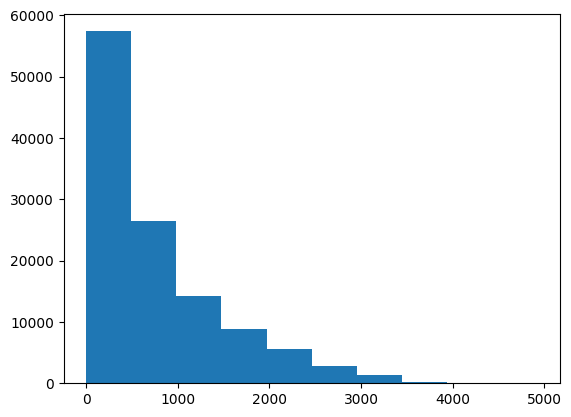

In [27]:
import matplotlib.pyplot as plt
asdf = data_df_emb['time'][data_df_emb['time']>0]
print(len(asdf[asdf>=3000]))
asdf = asdf[asdf<=5000]
plt.hist(asdf)


In [3]:
import torch

# Dummy data: 5 embeddings, each of dimension 3.
gene_emb = torch.tensor([
    [1.0, 2.0, 3.0],  # embedding for sample 0
    [4.0, 5.0, 6.0],  # sample 1
    [7.0, 8.0, 9.0],  # sample 2
    [1.0, 3.0, 5.0],  # sample 3
    [2.0, 4.0, 6.0]   # sample 4
])

# Dummy gene IDs for each embedding.
# For instance, gene ID 0 for samples 0 and 2, gene ID 1 for samples 1, 3, and 4.
gene_ids = torch.tensor([5, 1, 5, 1, 1])

# Determine the number of unique genes (assumes 0-indexed gene IDs)
num_genes = gene_ids.max().item() + 1  # 2 in this case
emb_dim = gene_emb.size(1)

# Initialize tensors to accumulate sums and counts per gene.
sum_embeddings = torch.zeros(num_genes, emb_dim)
count_embeddings = torch.zeros(num_genes)

# Expand gene_ids so that it matches the dimensions of gene_emb.
# This tells scatter_add which rows in sum_embeddings to add to.
indices = gene_ids.unsqueeze(-1).expand(-1, emb_dim)

# Scatter-add the gene embeddings into the sum_embeddings tensor.
sum_embeddings.scatter_add_(0, indices, gene_emb)

# Count how many embeddings correspond to each gene ID.
count_embeddings.scatter_add_(0, gene_ids, torch.ones_like(gene_ids, dtype=torch.float))

# Compute the average embedding for each gene.
gene_emb_avg = sum_embeddings / count_embeddings.unsqueeze(-1)

print("Sum of embeddings per gene:")
print(sum_embeddings)
print("\nCount per gene:")
print(count_embeddings)
print("\nAveraged embeddings per gene:")
print(gene_emb_avg)


Sum of embeddings per gene:
tensor([[ 0.,  0.,  0.],
        [ 7., 12., 17.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 8., 10., 12.]])

Count per gene:
tensor([0., 3., 0., 0., 0., 2.])

Averaged embeddings per gene:
tensor([[   nan,    nan,    nan],
        [2.3333, 4.0000, 5.6667],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [4.0000, 5.0000, 6.0000]])
